<a href="https://colab.research.google.com/github/Visna-dp/ml_shift/blob/main/entrance_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Конкурс "Турникеты"



Задача заключается в предсказании, кто вошел в здание по времени и турникету. Мы знаем, что "след" через турникеты принадлежит "Х". Кто этот "Х" предстоит вычислить по данным, которые нам известны. А ID юзеров известны по обучающей выборке (кроме нескольких новых!).

Решать данную задачу будем как задачу мультиклассификации, где таргет - это ID пользователя, который нужно предсказать.

### Установка окружения и импорт библиотек

In [ ]:
# устанавливаем окружение
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

# если работаем в колабе, подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Загрузка данных

In [ ]:
FILE_PATH_TRAIN = \
'/content/drive/MyDrive/SF_DS/data_shift/train.csv'
FILE_PATH_TEST = \
'/content/drive/MyDrive/SF_DS/data_shift/test.csv'

df_train = pd.read_csv(FILE_PATH_TRAIN, index_col=0, parse_dates=True)
df_test = pd.read_csv(FILE_PATH_TEST, index_col=0, parse_dates=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  37518 non-null  int64 
 1   ts       37518 non-null  object
 2   gate_id  37518 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ts         7125 non-null   object
 1   gate_id    7125 non-null   int64 
 2   user_word  7125 non-null   object
dtypes: int64(1), object(2)
memory usage: 222.7+ KB


### EDA + Feature engineering

Посмотрим уникальное количество пользователей и гейтов в тренировочной и тестовой выборках.

In [ ]:
df_train['user_id'].nunique(), df_test['user_word'].nunique()

(56, 34)

In [ ]:
df_train['gate_id'].nunique(), df_test['gate_id'].nunique()

(17, 16)

In [ ]:
# переведем дату в datetime
df_train['ts'] = pd.to_datetime(df_train['ts'])
df_test['ts'] = pd.to_datetime(df_test['ts'])

Посмотрим описательные статистики для даты и времени

In [ ]:
df_train['ts'].describe()

count                   37518
unique                  34068
top       2022-10-20 16:31:33
freq                        4
first     2022-07-29 09:08:54
last      2022-12-31 20:39:31
Name: ts, dtype: object

In [ ]:
df_test['ts'].describe()

count                    7125
unique                   6484
top       2023-01-11 13:48:11
freq                        3
first     2023-01-03 08:21:00
last      2023-02-24 19:44:09
Name: ts, dtype: object

Период в тренировочных данных: с 29-07-2022 по 31-12-2022 (5 месяцев), в тесте: с 03-01-2023 по 24-02-2023. Так как периоды не совпадают, при генерации фичей из даты нет смысла добавлять признак месяца и года.

Посмотрим и удалим дубликаты.

In [ ]:
df_train.duplicated().sum(), df_test.duplicated().sum()

(2346, 505)

In [ ]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)
df_train.duplicated().sum(), df_test.duplicated().sum()

(0, 0)

Для генерации признаков из даты загрузим производственный календарь на 2022 и 2023 год.

In [ ]:
import json
from urllib.request import urlopen

data2022 = json.load(urlopen("https://production-calendar.ru/get/ru/2022/json?wsch=1"))
data2023 = json.load(urlopen("https://production-calendar.ru/get/ru/2023/json?wsch=1"))
product_calendar2022 = pd.DataFrame(data2022["days"])
product_calendar2023 = pd.DataFrame(data2023["days"])
product_calendar = pd.concat([product_calendar2022, product_calendar2023], ignore_index=True)
product_calendar['date'] = pd.to_datetime(product_calendar['date'], format='%d.%m.%Y').dt.date
product_calendar.head()

,date,type_id,type_text,note,week_day,working_hours
0,2022-01-01,3,Государственный праздник,Новогодние каникулы,сб,0
1,2022-01-02,3,Государственный праздник,Новогодние каникулы,вс,0
2,2022-01-03,3,Государственный праздник,Новогодние каникулы,пн,0
3,2022-01-04,3,Государственный праздник,Новогодние каникулы,вт,0
4,2022-01-05,3,Государственный праздник,Новогодние каникулы,ср,0


In [ ]:
# функция для генерации признаков из даты
def create_date_features(df):

    df['day'] = df['ts'].dt.day
    df['dayofweek'] = df['ts'].dt.dayofweek
    df['week_end'] = df['dayofweek'].isin([5,6]).astype(int)
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['date'] = df['ts'].dt.date
    df = pd.merge(
        df,
        product_calendar[['date', 'type_id']],
        on='date',
        how='left'
    ).rename(columns={'type_id': 'type_day'})

    return df

In [ ]:
# извлекаем признаки из даты на трейне
df_train = create_date_features(df_train)
df_train.head()

,user_id,ts,gate_id,day,dayofweek,week_end,hour,minute,date,type_day
0,18,2022-07-29 09:08:54,7,29,4,0,9,8,2022-07-29,1
1,18,2022-07-29 09:09:54,9,29,4,0,9,9,2022-07-29,1
2,18,2022-07-29 09:10:06,5,29,4,0,9,10,2022-07-29,1
3,18,2022-07-29 09:10:08,5,29,4,0,9,10,2022-07-29,1
4,18,2022-07-29 09:10:34,10,29,4,0,9,10,2022-07-29,1


In [ ]:
# извлекаем признаки из даты на тесте
df_test = create_date_features(df_test)
df_test.head()

,ts,gate_id,user_word,day,dayofweek,week_end,hour,minute,date,type_day
0,2023-01-03 08:21:00,9,gini,3,1,0,8,21,2023-01-03,3
1,2023-01-03 08:21:18,5,gini,3,1,0,8,21,2023-01-03,3
2,2023-01-03 08:21:19,5,gini,3,1,0,8,21,2023-01-03,3
3,2023-01-03 08:21:39,10,gini,3,1,0,8,21,2023-01-03,3
4,2023-01-03 08:32:49,15,epsilon,3,1,0,8,32,2023-01-03,3


Посмотрим среднее значение количества строк в день по пользователям.

In [ ]:
df_train.groupby(['user_id', 'date'])['ts'].count().mean(), \
df_test.groupby(['user_word', 'date'])['ts'].count().mean()

(13.951606505355018, 12.304832713754648)

Построим временной ряд количества записей по всем пользователям, количества уникальных пользователей и среднее количество наблюдений по пользователю в день на тренировочной и тестовой выборках.

<Axes: xlabel='date'>

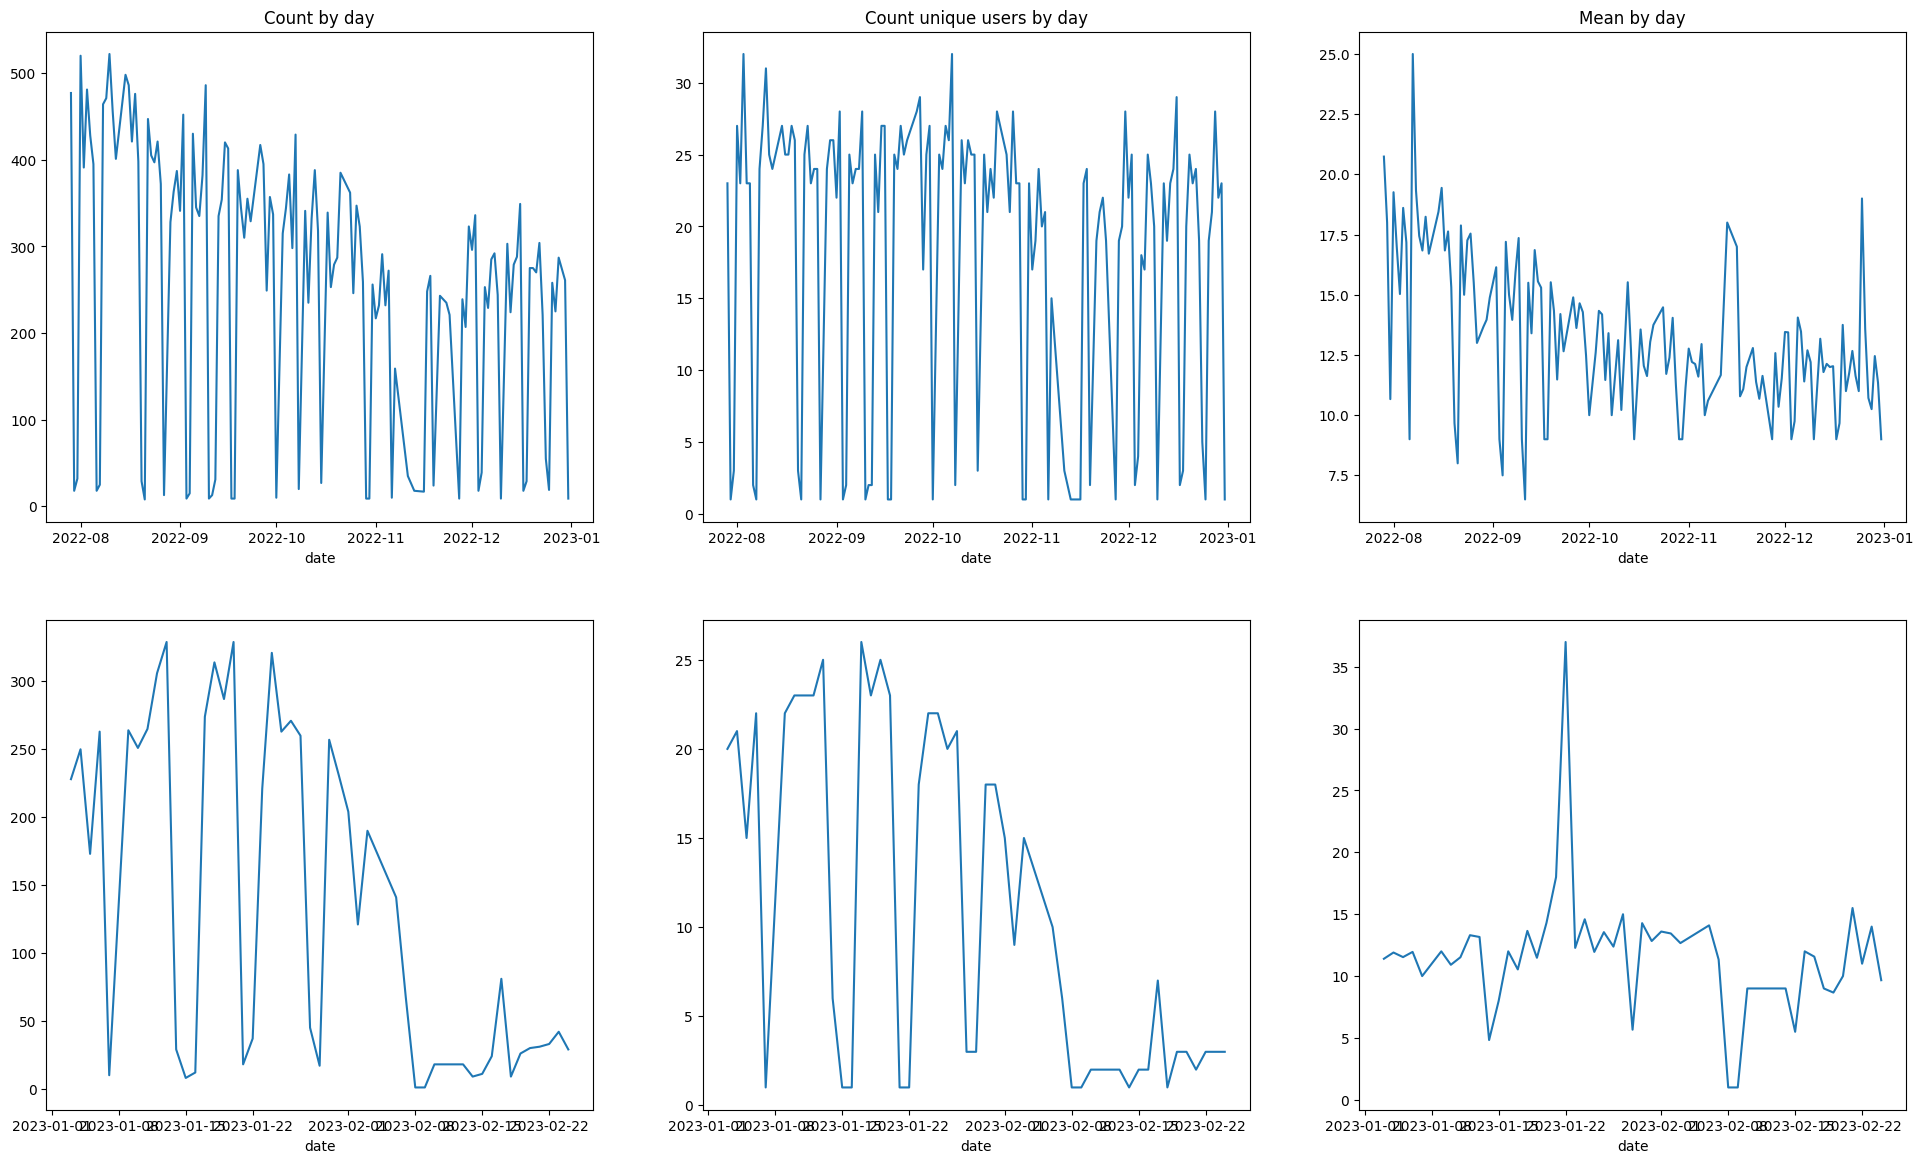

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(24, 14))

df_train.groupby(['date'])['user_id'].count().plot(title='Count by day', ax=axes[0,0])
df_train.groupby(['date'])['user_id'].nunique().plot(title='Count unique users by day', ax=axes[0,1])
df_train.groupby(['date','user_id'])['ts'].count().groupby('date').mean().plot(title='Mean by day', ax=axes[0,2])

df_test.groupby(['date'])['user_word'].count().plot(ax=axes[1,0])
df_test.groupby(['date'])['user_word'].nunique().plot(ax=axes[1,1])
df_test.groupby(['date','user_word'])['ts'].count().groupby('date').mean().plot(ax=axes[1,2])


Видим наличие тренда на уменьшение количества строк во времени и явно выраженную периодичность: вероятно, это недельные колебания (выходные, рабочие дни). С чем связан провал наблюдений после  08-02-2023 для тестовой выборки не понятно.

При этом среднее количество наблюдений для одного пользователя в день на тестовой выборке стабильно колеблется в районе 10-15, а на тренировочной выборке оно уменьшается с начала периода наблюдений, и начиная с 10.2022 также стабилизируется в районе 10-15.

Возможно, имеет смысл предать больший вес более поздним наблюдениям, так как:
- если у пользователя изменилась последовательность действий, то более поздние данные имеют большую ценность для предсказания последующих.
- чтобы данные на трейне и тесте имели более близкое распределения для увеличения точности предсказания.

In [ ]:
# преобразуем дату без времени в datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

Посмотрим распределение количества наблюдений по типу дня.

In [ ]:
fig = px.histogram(
    df_train.groupby(['date','week_end'])['ts'].count().reset_index(),
    x='ts',
    color='week_end'
)
fig.show()

In [ ]:
fig = px.histogram(
    df_test.groupby(['date','week_end'])['ts'].count().reset_index(),
    x='ts',
    color='week_end',
    nbins=10
)
fig.show()

На графиках видно, что количество наблюдений стремится к нулю в выходные дни. Хотя для тестовой выборки и среди рабочих дней есть большой пул дней с маленьким количеством наблюдений. Вероятно, это как раз провал после 08-02-2023, который мы видели на графике временного ряда.

Посмотрим распределение данных по часам.

In [ ]:
fig = px.histogram(df_train, x='hour')
fig.show()

In [ ]:
fig = px.histogram(df_test, x='hour')
fig.show()

На тестовых данных есть наблюдения в ночное время (часы с 0 до 6), которых нет на тренировочных данных. Посмотрим на них внимательней.

In [ ]:
df_test[df_test['hour'].isin(range(0,7))]

,ts,gate_id,user_word,day,dayofweek,week_end,hour,minute,date,type_day
2339,2023-01-14 00:52:52,11,sigmoid,14,5,1,0,52,2023-01-14,2
2340,2023-01-14 00:53:10,4,sigmoid,14,5,1,0,53,2023-01-14,2
2341,2023-01-14 00:53:12,4,sigmoid,14,5,1,0,53,2023-01-14,2
2342,2023-01-14 00:55:29,15,sigmoid,14,5,1,0,55,2023-01-14,2
2343,2023-01-14 01:11:05,12,f1,14,5,1,1,11,2023-01-14,2
2344,2023-01-14 03:15:26,11,collinear,14,5,1,3,15,2023-01-14,2
2345,2023-01-14 03:19:13,11,r2,14,5,1,3,19,2023-01-14,2
2346,2023-01-14 03:19:28,10,f1,14,5,1,3,19,2023-01-14,2
2347,2023-01-14 03:20:04,4,r2,14,5,1,3,20,2023-01-14,2
2348,2023-01-14 03:20:08,4,r2,14,5,1,3,20,2023-01-14,2


Все эти наблюдения приходятся на один день. Будем считать их выбросами и удалим из теста, чтобы избежать дрифта этой фичи.

In [ ]:
df_test.drop(df_test[df_test['hour'].isin([0,1,3])].index, inplace=True)

Для предсказания наиболее похожего пользователя хотелось бы учитывать последовательность его действий, так как эта информация у нас есть и на трейне и на тесте. Добавим в качестве признаков лаги для гейтов, и разницу во времени между текущим значением и лаговыми. Будем брать 12 лагов, предварительно удалив из трейновой выборки пользоватей, у которых меньше 10 наблюдений. Количество лагов выбрано таким образом, что оно равно среднему количество наблюдений за день по одному пользователю на тесте. Опытным путем установлено, что увеличение количества лагов не дает прироста скора предсказания.

In [ ]:
df_train.groupby(['user_id'])['ts'].count().sort_values().head(10)

user_id
4      1
51     2
44     4
52     5
21     5
5     10
30    10
38    13
10    17
8     27
Name: ts, dtype: int64

In [ ]:
# удалим из выборки пользователей, у которых меньше 10 наблюдений
users = df_train.groupby(['user_id'])['ts'].count().sort_values().head(5).index
df_train.drop(df_train[df_train['user_id'].isin(users)].index, inplace=True)

Посмотрим на уникальные номера гейтов в трейне и тесте.

In [ ]:
df_train['gate_id'].unique()

array([ 7,  9,  5, 10, 11,  4, 12,  3, 15,  6, 13, -1,  8,  1,  0, 16, 14])

In [ ]:
df_test['gate_id'].unique()

array([ 9,  5, 10, 15,  7,  3, 11,  4,  6, 12, 13,  8,  2,  1, 14, -1])

Удалим из трейна гейты, которых нет на тесте, а из теста, которых нет на трейне.

In [ ]:
dropped_gates = len(df_train[df_train['gate_id'].isin([0, 16])].index)
df_train.drop(df_train[df_train['gate_id'].isin([0, 16])].index, inplace=True)
print('Удалили', dropped_gates, 'наблюдений на трейне')

Удалили 5 наблюдений на трейне


In [ ]:
dropped_gates = len(df_test[df_test['gate_id'].isin([2])].index)
df_test.drop(df_test[df_test['gate_id'].isin([2])].index, inplace=True)
print('Удалили', dropped_gates, 'наблюдений на тесте')

Удалили 4 наблюдений на тесте


In [ ]:
# проверим, что количество уникальных гейтов совпадает на трейне и тесте
df_test['gate_id'].nunique(), df_train['gate_id'].nunique()

(15, 15)

In [ ]:
# отсортируем датафрейм по времени
df_train = df_train.sort_values('ts')
df_test = df_test.sort_values('ts')

In [ ]:
# генерируем лаги на трейне
for i in range(1, 13, 1):
    df_train['lag_gate_'+str(i)] = df_train.sort_values('ts').groupby('user_id')['gate_id'].shift(i)
    df_train['time_diff_'+str(i)] = df_train.sort_values('ts').groupby('user_id')['ts'].diff(i).dt.total_seconds()

df_train.tail()

,user_id,ts,gate_id,day,dayofweek,week_end,hour,minute,date,type_day,...,lag_gate_8,time_diff_8,lag_gate_9,time_diff_9,lag_gate_10,time_diff_10,lag_gate_11,time_diff_11,lag_gate_12,time_diff_12
35167,6,2022-12-31 17:21:19,10,31,5,1,17,21,2022-12-31,2,...,10.0,80251.0,13.0,80525.0,13.0,80526.0,10.0,92184.0,10.0,96056.0
35168,6,2022-12-31 20:38:56,11,31,5,1,20,38,2022-12-31,2,...,11.0,91969.0,10.0,92108.0,13.0,92382.0,13.0,92383.0,10.0,104041.0
35169,6,2022-12-31 20:39:22,6,31,5,1,20,39,2022-12-31,2,...,4.0,91971.0,11.0,91995.0,10.0,92134.0,13.0,92408.0,13.0,92409.0
35170,6,2022-12-31 20:39:23,6,31,5,1,20,39,2022-12-31,2,...,4.0,91970.0,4.0,91972.0,11.0,91996.0,10.0,92135.0,13.0,92409.0
35171,6,2022-12-31 20:39:31,9,31,5,1,20,39,2022-12-31,2,...,7.0,11996.0,4.0,91978.0,4.0,91980.0,11.0,92004.0,10.0,92143.0


In [ ]:
# генерируем лаги на тесте
for i in range(1, 13, 1):
    df_test['lag_gate_'+str(i)] = df_test.sort_values('ts').groupby('user_word')['gate_id'].shift(i)
    df_test['time_diff_'+str(i)] = df_test.sort_values('ts').groupby('user_word')['ts'].diff(i).dt.total_seconds()

df_test.tail()

,ts,gate_id,user_word,day,dayofweek,week_end,hour,minute,date,type_day,...,lag_gate_8,time_diff_8,lag_gate_9,time_diff_9,lag_gate_10,time_diff_10,lag_gate_11,time_diff_11,lag_gate_12,time_diff_12
6615,2023-02-24 17:08:57,10,collinear,24,4,0,17,8,2023-02-24,6,...,4.0,71083.0,4.0,71085.0,11.0,71109.0,10.0,78419.0,3.0,78441.0
6616,2023-02-24 19:43:36,11,collinear,24,4,0,19,43,2023-02-24,6,...,9.0,80355.0,4.0,80362.0,4.0,80364.0,11.0,80388.0,10.0,87698.0
6617,2023-02-24 19:44:00,4,collinear,24,4,0,19,44,2023-02-24,6,...,7.0,34264.0,9.0,80379.0,4.0,80386.0,4.0,80388.0,11.0,80412.0
6618,2023-02-24 19:44:01,4,collinear,24,4,0,19,44,2023-02-24,6,...,9.0,34208.0,7.0,34265.0,9.0,80380.0,4.0,80387.0,4.0,80389.0
6619,2023-02-24 19:44:09,9,collinear,24,4,0,19,44,2023-02-24,6,...,3.0,34197.0,9.0,34216.0,7.0,34273.0,9.0,80388.0,4.0,80395.0


Добавим фичи времени (час) и гейта для первого и последнего наблюдения для пользователя за текущий день.

In [ ]:
df_train = df_train.merge(
    df_train.groupby(['user_id','date'])['hour'].agg(['first','last']).reset_index().rename(
        columns={'first': 'hour_first', 'last': 'hour_last'}
    ),
    how='left',
    on=['user_id','date']
)

df_train = df_train.merge(
    df_train.groupby(['user_id','date'])['gate_id'].agg(['first','last']).reset_index().rename(
        columns={'first': 'gate_first', 'last': 'gate_last'}
    ),
    how='left',
    on=['user_id','date']
)

df_train.head()

,user_id,ts,gate_id,day,dayofweek,week_end,hour,minute,date,type_day,...,lag_gate_10,time_diff_10,lag_gate_11,time_diff_11,lag_gate_12,time_diff_12,hour_first,hour_last,gate_first,gate_last
0,18,2022-07-29 09:08:54,7,29,4,0,9,8,2022-07-29,1,...,NaN,NaN,NaN,NaN,NaN,NaN,9,18,7,9
1,18,2022-07-29 09:09:54,9,29,4,0,9,9,2022-07-29,1,...,NaN,NaN,NaN,NaN,NaN,NaN,9,18,7,9
2,18,2022-07-29 09:10:06,5,29,4,0,9,10,2022-07-29,1,...,NaN,NaN,NaN,NaN,NaN,NaN,9,18,7,9
3,18,2022-07-29 09:10:08,5,29,4,0,9,10,2022-07-29,1,...,NaN,NaN,NaN,NaN,NaN,NaN,9,18,7,9
4,18,2022-07-29 09:10:34,10,29,4,0,9,10,2022-07-29,1,...,NaN,NaN,NaN,NaN,NaN,NaN,9,18,7,9


In [ ]:
df_test = df_test.merge(
    df_test.groupby(['user_word','date'])['hour'].agg(['first','last']).reset_index().rename(
        columns={'first': 'hour_first', 'last': 'hour_last'}
    ),
    how='left',
    on=['user_word','date']
)

df_test = df_test.merge(
    df_test.groupby(['user_word','date'])['gate_id'].agg(['first','last']).reset_index().rename(
        columns={'first': 'gate_first', 'last': 'gate_last'}
    ),
    how='left',
    on=['user_word','date']
)

df_test.head()

,ts,gate_id,user_word,day,dayofweek,week_end,hour,minute,date,type_day,...,lag_gate_10,time_diff_10,lag_gate_11,time_diff_11,lag_gate_12,time_diff_12,hour_first,hour_last,gate_first,gate_last
0,2023-01-03 08:21:00,9,gini,3,1,0,8,21,2023-01-03,3,...,NaN,NaN,NaN,NaN,NaN,NaN,8,17,9,4
1,2023-01-03 08:21:18,5,gini,3,1,0,8,21,2023-01-03,3,...,NaN,NaN,NaN,NaN,NaN,NaN,8,17,9,4
2,2023-01-03 08:21:19,5,gini,3,1,0,8,21,2023-01-03,3,...,NaN,NaN,NaN,NaN,NaN,NaN,8,17,9,4
3,2023-01-03 08:21:39,10,gini,3,1,0,8,21,2023-01-03,3,...,NaN,NaN,NaN,NaN,NaN,NaN,8,17,9,4
4,2023-01-03 08:32:49,15,epsilon,3,1,0,8,32,2023-01-03,3,...,NaN,NaN,NaN,NaN,NaN,NaN,8,17,15,15


### Моделирование

Для моделирования будем использовать реализацию градиентного бустинга из библиотеки CatBoost из-за её удобства работы с категориальными фичами, которых у нас достаточно много.

Проведем необходиму предобработку данных:
- Пропуски присутствуют в категориальных фичах 'lag_gate_%'. Заполним их 0, так как гейта с таким номером у нас нет.
- Все категориальные фичи у нас представлены целыми числами, преобразуем их к типу int.

Будем использовать веса классов, чтобы сбалансировать выборку по классам, а также веса наблюдений, чтобы придать больший вес наблюдениям после 10.2022

Для валидации модели воспользуемся кросс-валидацией со стратификацией, так как классы сильно не сбалансированы.
Разбиение на фолды будем проводить без перемешивания, чтобы избежать лика и переобучения модели на трейне.

In [ ]:
# зададим веса наблюдений
weights = df_train['date'].apply(lambda x: 1.5 if x >= pd.to_datetime('2022-10-01', format='%Y-%m-%d') else 0.8)


In [ ]:
from sklearn.utils import class_weight

# зададим веса классам
class_weight_vect = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(df_train['user_id']),
    y=df_train['user_id']
    )

In [ ]:
# категориальные фичи
cat_features = [
    'gate_id', 'day', 'dayofweek', 'week_end', 'hour', 'type_day', 'lag_gate_1',
    'lag_gate_2', 'lag_gate_3', 'lag_gate_4','lag_gate_5', 'lag_gate_6',
    'lag_gate_7', 'lag_gate_8', 'lag_gate_9', 'lag_gate_10',
    'lag_gate_11', 'lag_gate_12',
    'hour_first',	'hour_last',	'gate_first',	'gate_last'
]
# заполним пропуски
df_train[cat_features] = df_train[cat_features].fillna(0)
df_test[cat_features] = df_test[cat_features].fillna(0)
# переведем в тим int
df_train[cat_features] = df_train[cat_features].astype('int')
df_test[cat_features] = df_test[cat_features].astype('int')

In [ ]:
kf = StratifiedKFold(n_splits=5)

models = []
metrics_kf = []

for j, (train_index, test_index) in enumerate(kf.split(
    df_train.drop(['ts', 'user_id', 'date'], axis=1), df_train['user_id']
    )):
        print(f'Training with fold {j} started.')
        model_kf = CatBoostClassifier(
                cat_features = cat_features,
                random_seed = 42,
                # используем GPU по возможности, так обучение значительно быстрее
                task_type='GPU',
                verbose=500,
                early_stopping_rounds=100,
                class_weights=class_weight_vect,
        )

        model_kf.fit(
                    X = df_train.drop(['ts', 'user_id', 'date'], axis=1).iloc[train_index],
                    y = df_train.iloc[train_index]['user_id'],
                    eval_set=(df_train.drop(['ts', 'user_id', 'date'], axis=1).iloc[test_index],
                              df_train.iloc[test_index]['user_id']),
                    sample_weight = weights.iloc[train_index]
        )

        preds_train = model_kf.predict(df_train.drop(['ts', 'user_id', 'date'], axis=1).iloc[train_index])
        preds_test = model_kf.predict(df_train.drop(['ts', 'user_id', 'date'], axis=1).iloc[test_index])
        metric_train = metrics.accuracy_score(df_train.iloc[train_index]['user_id'], preds_train)
        metric = metrics.accuracy_score(df_train.iloc[test_index]['user_id'], preds_test)
        print(f'Accuracy for train: {metric_train:.2f}')
        print(f'Accuracy for test: {metric:.2f}')
        print(f'Training with fold {j} completed.')

        metrics_kf.append(metric)
        models.append(model_kf)

metrics_kf


Training with fold 0 started.
Learning rate set to 0.147293
0:	learn: 3.5632579	test: 3.9326793	best: 3.9326793 (0)	total: 226ms	remaining: 3m 45s
bestTest = 2.424818758
bestIteration = 89
Shrink model to first 90 iterations.
Accuracy for train: 0.64
Accuracy for test: 0.34
Training with fold 0 completed.
Training with fold 1 started.
Learning rate set to 0.147293
0:	learn: 3.5970091	test: 3.8537132	best: 3.8537132 (0)	total: 65.7ms	remaining: 1m 5s
bestTest = 1.939594884
bestIteration = 168
Shrink model to first 169 iterations.
Accuracy for train: 0.73
Accuracy for test: 0.43
Training with fold 1 completed.
Training with fold 2 started.
Learning rate set to 0.147293
0:	learn: 3.5189345	test: 3.7520033	best: 3.7520033 (0)	total: 62ms	remaining: 1m 1s
bestTest = 1.798270188
bestIteration = 395
Shrink model to first 396 iterations.
Accuracy for train: 0.88
Accuracy for test: 0.48
Training with fold 2 completed.
Training with fold 3 started.
Learning rate set to 0.147293
0:	learn: 3.47979

[0.3386913229018492,
 0.42930298719772403,
 0.4786628733997155,
 0.3704125177809388,
 0.3285917496443812]

### Предсказание и подготовка сабмита.

Подготовку итогового сабмита будем выполнять следующим образом:
1. Сделаем предсказание для каждой строки тестовой выборки.
2. Сгруппируем предсказания по пользователям, получив по каждому пользователю среднее значение вероятности каждого класса.
3. Распределим предсказания по убыванию вероятностей. То есть сначала найдем самое максимальное значение вероятности, запишем его соответствующему пользователю, затем следующее и т.д. чтобы избежать повторений user_id в итоговом предсказании.
4. Пользователям, для которых вероятность будет меньше определенного порога (0.06) присвоим значение -999 (новый пользователь). Значение порога подобрано таким образом, чтобы новых пользователей было примерно 10%.

In [ ]:
# предсказание на кросс-валидации
preds_proba_kf = np.zeros([len(df_test), len(models[0].classes_)])

for model_kf in models:
    preds_proba_kf += model_kf.predict_proba(
        df_test.drop(['ts', 'user_word','date'], axis=1)
        )/len(models)

In [ ]:
result = df_test[['user_word']]
result['preds_proba'] = list(preds_proba_kf)


result_df = pd.DataFrame(result.groupby('user_word')['preds_proba'].mean())
result_df['preds_proba'] = result_df['preds_proba'].apply(lambda x: dict(zip(models[0].classes_, x)))

pivot = pd.concat(
    [result_df.reset_index(), pd.json_normalize(result_df['preds_proba'])],
    axis=1
    ).set_index('user_word').drop('preds_proba', axis=1)

preds_result = pivot.copy()
temp = preds_result.copy()
for i in preds_result.index:
    best_score = temp.max().max()
    best = temp.max().idxmax()
    preds_result.loc[temp.max(axis=1).idxmax(), 'best'] = best
    preds_result.loc[temp.max(axis=1).idxmax(), 'best_score'] = best_score
    temp.drop(temp.max(axis=1).idxmax(), axis=0, inplace=True)
    temp.drop(best, axis=1, inplace=True)
preds_result[['best','best_score']]

,best,best_score
user_word,,
aucroc,24.0,0.361973
binary,12.0,0.409222
blue,5.0,0.078655
categorical,14.0,0.601646
coefficient,27.0,0.101896
collinear,40.0,0.023803
distributed,0.0,0.158150
epsilon,1.0,0.565419
f1,6.0,0.276943


In [ ]:
preds_result.loc[preds_result['best_score'] < 0.06,['best','best_score']]

,best,best_score
user_word,,
collinear,40.0,0.023803
regression,53.0,0.038121
y,45.0,0.052757


In [ ]:
preds_result.loc[preds_result['best_score'] < 0.06,'best'] = -999

preds_result['best'] = preds_result['best'].astype(int)
submit = preds_result[['best']].reset_index().rename(
    columns={'index':'user_word', 'best':'preds'})
submit.to_csv('answer.csv', index=False)

In [ ]:
submit

,user_word,preds
0,aucroc,24
1,binary,12
2,blue,5
3,categorical,14
4,coefficient,27
5,collinear,-999
6,distributed,0
7,epsilon,1
8,f1,6
9,fit,23
